# DEMOGRAPHIC HEALTH

### Analyzing the Impact of Sociodemographic Factors on Health Resources Using Regularized Linear Regression

In [565]:
#Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import joblib
import os
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Health Resource and Sociodemographic Analysis:** What sociodemographic factors are most linked to health resource availability in US counties? Do income, education, or poverty rates influence access to health resources?

**Disparities Across Demographics:** Are health resources distributed equally across counties with diverse racial, ethnic, or age compositions? How does family structure impact resource allocation?

**Economic and Geographic Influences:** Do economic factors, like income or unemployment, affect health resources? Are rural counties less equipped compared to urban areas?

**Predictive Modeling of Health Resources:** Can regularized linear regression effectively predict health resource distribution? Which factors have the strongest predictive power?


***1.2 DATA COLLECTION***

In [495]:
pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

In [496]:
df.to_csv("../data/raw/medical_insurance_data.csv", index=False)

**STEP 2: EXPLORATION & DATA CLEANING**

***2.1. EXPLORATION***

****2.1.1 Understanding the features****

To answer the above questions and develop a predictive model, we collected data on the following variables:

**1. Geographic Identification**

* `fips`: FIPS code for the county
* `STATE_FIPS`: FIPS code for the state
* `Urban_rural_code`: Urban/rural area classification

**2. Demographics and Age**

* `TOT_POP`: Total population
* Age groups (population and percentage of total):
    * `0-9`, `10-19`, `20-29`, `30-39`, `40-49`, `50-59`, `60-69`, `70-79`, `80+`
    * Percentage of the population in each age group (`0-9 y/o % of total pop`, etc.)
* Elderly population:
    * `Population Aged 60+`: Population aged 60+
    * `Percent of Population Aged 60+`: Percentage of the population aged 60+
* `county_pop2018_18 and older`: Population aged 18+ in 2018

**3. Race and Ethnicity**
* Population by racial group:
    * `White-alone pop`, `Black-alone pop`, `Native American/American Indian-alone pop`, `Asian-alone pop`, `Hawaiian/Pacific Islander-alone pop`, `Two or more races pop`
* Percentage by racial group:
    * `% White-alone`, `% Black-alone`, `% NA/AI-alone`, `% Asian-alone`, `% Hawaiian/PI-alone`, `% Two or more races`
    
**4. Population Change and Migration**
* `N_POP_CHG_2018`: Numeric change in resident population (2017-2018)
* `GQ_ESTIMATES_2018`: Group quarters population estimate (2018)
* Birth, death, and migration rates:
    * `R_birth_2018`, `R_death_2018`, `R_NATURAL_INC_2018`, `R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`

**5. Education**
* Education levels (count and percentage):
    * `Less than a high school diploma 2014-18`, `High school diploma only 2014-18`, `Some college or associate's degree 2014-18`, `Bachelor's degree or higher 2014-18`
    * Corresponding percentages: `Percent of adults with less than a high school diploma 2014-18`, `Percent of adults with a high school diploma only 2014-18`, etc.
    
**6. Poverty and Income**

* `POVALL_2018`: Estimated number of people of all ages in poverty (2018)
* Poverty percentages:
    * `PCTPOVALL_2018`: Percentage of people in poverty (2018)
    * `PCTPOV017_2018`: Percentage of people under age 17 in poverty (2018)
    * `PCTPOV517_2018`: Percentage of children aged 5-17 in poverty
* Household income:
    * `MEDHHINC_2018`: Median household income estimate (2018)
    * 90% confidence interval for median household income: `CI90LBINC_2018` (lower bound), `CI90UBINC_2018` (upper bound)
    * `Med_HH_Income_Percent_of_State_Total_2018`: County median household income as a percent of state median (2018)

**7. Employment**

* `Civilian_labor_force_2018`: Civilian labor force annual average
* `Employed_2018`: Number of employed individuals (annual average)
* `Unemployed_2018`: Number of unemployed individuals (annual average)
* `Unemployment_rate_2018`: Unemployment rate

**8. Health Resources and Infrastructure**

* Health professionals per 100,000 population (2018):
    * `Active Physicians per 100000 Population 2018 (AAMC)`: Active physicians
    * `Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)`: Active primary care physicians
    * `Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)`: Primary care patient care physicians
    * `Active General Surgeons per 100000 Population 2018 (AAMC)`: General surgeons
* Nursing and medical assistance professionals (2019):
    * `Total nurse practitioners (2019)`, `Total physician assistants (2019)`, etc.
* Hospital infrastructure:
    * `Total Hospitals (2019)`: Total number of hospitals
    * `ICU Beds_x`: Number of ICU beds per county

**9. Health Conditions Prevalence**

* General health conditions:
    * `anycondition_prevalence`, `anycondition_Lower 95% CI`, `anycondition_Upper 95% CI`, `anycondition_number`
* Obesity prevalence:
    * `Obesity_prevalence`, `Obesity_Lower 95% CI`, `Obesity_Upper 95% CI`, `Obesity_number`
* Other conditions:
    * `Heart disease_prevalence`, `COPD_prevalence`, `diabetes_prevalence`, `CKD_prevalence` (each with prevalence rates, confidence intervals, and population counts)

In [497]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(df.shape)

Dataset dimensions:
(3140, 108)


In [498]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(df.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


In [499]:
# Analyze the types of information we have
print("Data types present in the dataset:", df.dtypes.unique())

# Identify numerical and categorical variables
numerical_vars = df.select_dtypes(include=['float', 'int']).columns
categorical_vars = df.select_dtypes(include=['O']).columns

# Count the number of numerical and categorical variables
num_numerical_vars = len(numerical_vars)
num_categorical_vars = len(categorical_vars)

print(f"Number of categorical variables: {num_categorical_vars}")
print("Categorical variables:", list(categorical_vars))
print('\n')
print(f"Number of numerical variables: {num_numerical_vars}")
print("Numerical variables:", list(numerical_vars))

Data types present in the dataset: [dtype('int64') dtype('float64') dtype('O')]
Number of categorical variables: 2
Categorical variables: ['COUNTY_NAME', 'STATE_NAME']


Number of numerical variables: 106
Numerical variables: ['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOM

#### Statements

* This DataFame is composed by 3140 rows and 108 columns (variables).
* The data has:
    * 2 categorical variables
    * 106 numerical variables

**2.2 DATA CLEANING**

***2.2.1 ELIMINATE DUPLICATES***

In this step, I will eliminate duplicates, which is essential to ensure data integrity. Duplicates can distort analyses, introduce bias, and affect model accuracy. This step helps keep the dataset clean by representing each input uniquely and reliably. 

In [500]:
# Display initial row count
initial_row_count = df.shape[0]

# Check and remove duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicate rows have been removed. Row count reduced from {initial_row_count} to {df.shape[0]}.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


* there are no duplicates ​​in this dataframe.

***2.2.2 ELIMINATE IRRELEVANT INFORMATION***

#### Statement:
To simplify and focus our analysis on the relationship between sociodemographic factors and healthcare resources, some variables were identified as irrelevant and eliminated. These variables include geographic codes and identifiers (`flips` and `STATE_FIPS`), details about population changes and migration (`R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`, `N_POP_CHG_2018`), confidence intervals around income (`CI90LBINC_2018`, `CI90UBINC_2018`), overly granular racial and age distribution details, and other redundant information that does not directly contribute to the analytical objectives. Removing these variables ensures that our dataset remains focused on the key variables, reducing noise and improving processing and modeling efficiency.

In [501]:
irrelevant_variables = ['80+ y/o % of total pop',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'CKD_Lower 95% CI',
 'Unemployment_rate_2018',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'CKD_Upper 95% CI',
 'Obesity_Upper 95% CI',
 'ICU Beds_x',
 'Civilian_labor_force_2018',
 '0-9 y/o % of total pop',
 'diabetes_number',
 '20-29',
 'POVALL_2018',
 'CI90UBINC_2018',
 'COPD_Lower 95% CI',
 '40-49 y/o % of total pop',
 '70-79 y/o % of total pop',
 'Heart disease_Upper 95% CI',
 '19-Oct',
 'anycondition_Lower 95% CI',
 '30-39',
 'Heart disease_number',
 'Obesity_Lower 95% CI',
 'anycondition_number',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'R_DOMESTIC_MIG_2018',
 'CNTY_FIPS',
 'CKD_number',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'PCTPOVALL_2018',
 'COPD_Upper 95% CI',
 'diabetes_Lower 95% CI',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total nurse practitioners (2019)',
 'COPD_prevalence',
 '50-59 y/o % of total pop',
 'anycondition_Upper 95% CI',
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'Less than a high school diploma 2014-18',
 '50-59',
 'R_INTERNATIONAL_MIG_2018',
 '30-39 y/o % of total pop',
 'R_NET_MIG_2018',
 'diabetes_Upper 95% CI',
 'High school diploma only 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 'GQ_ESTIMATES_2018',
 '10-19 y/o % of total pop',
 'Total physician assistants (2019)',
 'Employed_2018',
 'R_NATURAL_INC_2018',
 '40-49',
 'CI90LBINC_2018',
 '60-69 y/o % of total pop',
 'Total Population',
 'R_birth_2018',
 'COPD_number',
 'Internal Medicine Primary Care (2019)',
 'POP_ESTIMATE_2018',
 'Percent of Population Aged 60+',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'anycondition_prevalence',
 'county_pop2018_18 and older',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'N_POP_CHG_2018',
 '0-9',
 'Heart disease_Lower 95% CI',
 'Obesity_number',
 'Median_Household_Income_2018',
 'CKD_prevalence',
 "Percent of adults completing some college or associate's degree 2014-18",
 'fips',
 'STATE_FIPS',
 '20-29 y/o % of total pop',
 'Unemployed_2018',
 'Urban_rural_code',
 'Total Specialist Physicians (2019)',
 'R_death_2018',
 'Percent of adults with less than a high school diploma 2014-18']


In [502]:
df = df.drop(columns=[col for col in irrelevant_variables if col in df.columns])

print("Remaining columns in the dataset:")
print(df.columns)



Remaining columns in the dataset:
Index(['TOT_POP', '60-69', '70-79', '80+', 'White-alone pop', '% White-alone',
       'Black-alone pop', '% Black-alone',
       'Native American/American Indian-alone pop', '% NA/AI-alone',
       'Asian-alone pop', '% Asian-alone',
       'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone',
       'Two or more races pop', '% Two or more races',
       'Some college or associate's degree 2014-18',
       'Bachelor's degree or higher 2014-18', 'PCTPOV017_2018',
       'PCTPOV517_2018', 'MEDHHINC_2018',
       'Active Physicians per 100000 Population 2018 (AAMC)',
       'Total Hospitals (2019)', 'Population Aged 60+', 'COUNTY_NAME',
       'STATE_NAME', 'Obesity_prevalence', 'Heart disease_prevalence',
       'diabetes_prevalence'],
      dtype='object')


In [503]:
df.head()

,TOT_POP,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence
0,55601,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,10552,10291,19.3,19.5,59338,217.1,1.148905,10523,Autauga,Alabama,35.8,7.9,12.9
1,218022,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,46025,46075,13.9,13.1,57588,217.1,4.505074,53519,Baldwin,Alabama,29.7,7.8,12.0
2,24881,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,4566,2220,43.9,36.7,34382,217.1,0.514126,6150,Barbour,Alabama,40.7,11.0,19.7
3,22400,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,3846,1813,27.8,26.3,46064,217.1,0.462860,4773,Bibb,Alabama,38.7,8.6,14.1
4,57840,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,13267,5010,18.0,15.5,50412,217.1,1.195171,13600,Blount,Alabama,34.0,9.2,13.5


In [504]:
print("Columns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['TOT_POP', '60-69', '70-79', '80+', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18", 'PCTPOV017_2018', 'PCTPOV517_2018', 'MEDHHINC_2018', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Total Hospitals (2019)', 'Population Aged 60+', 'COUNTY_NAME', 'STATE_NAME', 'Obesity_prevalence', 'Heart disease_prevalence', 'diabetes_prevalence']


**STEP 3: ANALYSIS OF UNIVARIATE VARIABLES**

In [505]:
num = ['int64', 'float64']
cat = ['O']

df_numerical = df.select_dtypes(num)
df_categorical = df.select_dtypes(cat)

**3.1 ANALYSIS OF CATEGORICAL VARIABLES**

In [506]:
df_categorical.head(3)

,COUNTY_NAME,STATE_NAME
0,Autauga,Alabama
1,Baldwin,Alabama
2,Barbour,Alabama


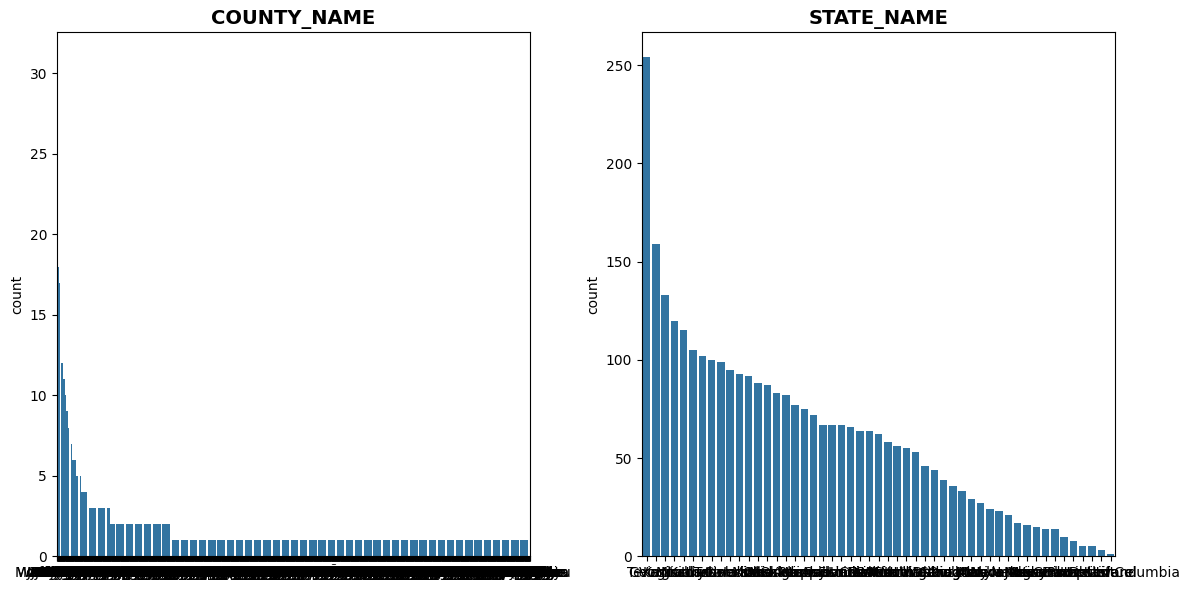

In [507]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for 'COUNTY_NAME'
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index)
ax[0].set_title("COUNTY_NAME", fontsize=14, fontweight='bold')
ax[0].set_xlabel(None) 

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index)
ax[1].set_title("STATE_NAME", fontsize=14, fontweight='bold')
ax[1].set_xlabel(None) 


plt.tight_layout()
plt.show()


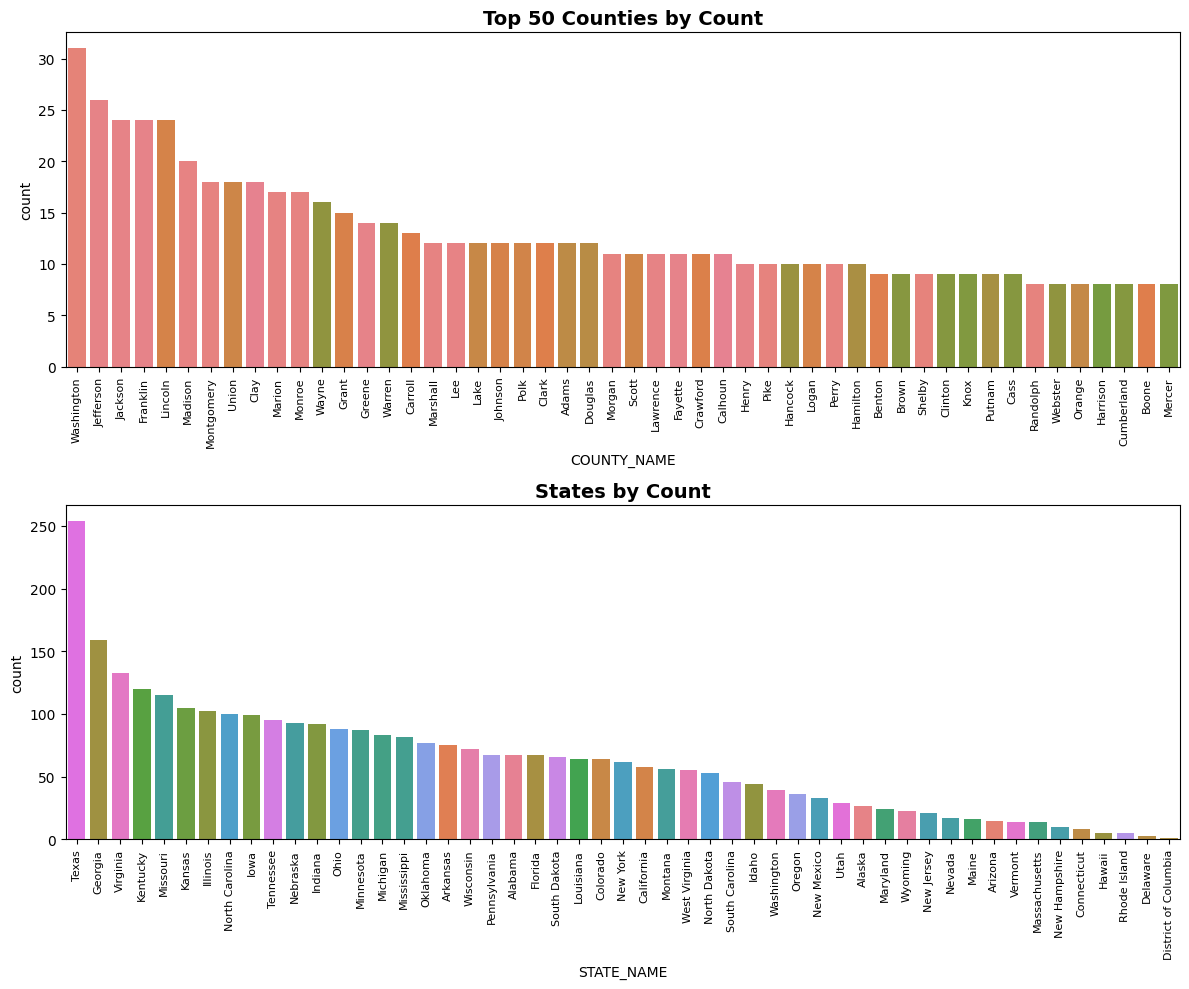

In [508]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot for 'COUNTY_NAME' - Top 50
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index[:50], hue='COUNTY_NAME')
ax[0].set_title("Top 50 Counties by Count", fontsize=14, fontweight='bold')

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index, hue='STATE_NAME')
ax[1].set_title("States by Count", fontsize=14, fontweight='bold')


for a in ax:
    a.tick_params(axis='x', labelrotation=90, labelsize=8)

plt.tight_layout()
plt.show()



#### Statements

* Texas has significantly more counties than any other state, indicating a unique administrative structure with a greater number of subdivisions. This suggests that Texas may have unique local governance needs, which could impact the distribution of health care resources and services.

* Southern and Midwestern states, such as Georgia and Kentucky, also have high county counts. This pattern suggests that these regions tend to have more subdivisions, possibly to facilitate governance over large areas with distributed populations. This may reflect a preference for a more decentralized governance structure in these states.

* Smaller or more urbanized states, especially in the Northeast and West (such as Delaware and the District of Columbia), have fewer counties. This may indicate a preference for more centralized governance in these areas, where population density allows for efficient administration with fewer subdivisions.

* The county chart shows that names such as Washington, Jefferson, and Franklin are common in many parts of the U.S., with multiple counties of the same name in different states.

**3.2 ANALYSIS OF NUMERICAL VARIABLES**

In [509]:
list(df_numerical.head(3))

['TOT_POP',
 '60-69',
 '70-79',
 '80+',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Hospitals (2019)',
 'Population Aged 60+',
 'Obesity_prevalence',
 'Heart disease_prevalence',
 'diabetes_prevalence']

**note** - Instead of choosing the raw number of cases, prevalence percentages (e.g., Obesity_prevalence, diabetes_prevalence, and Heart disease_prevalence) were selected to normalize for population size, facilitating comparative analysis across counties of varying sizes and allowing for more accurate identification of health disparities.

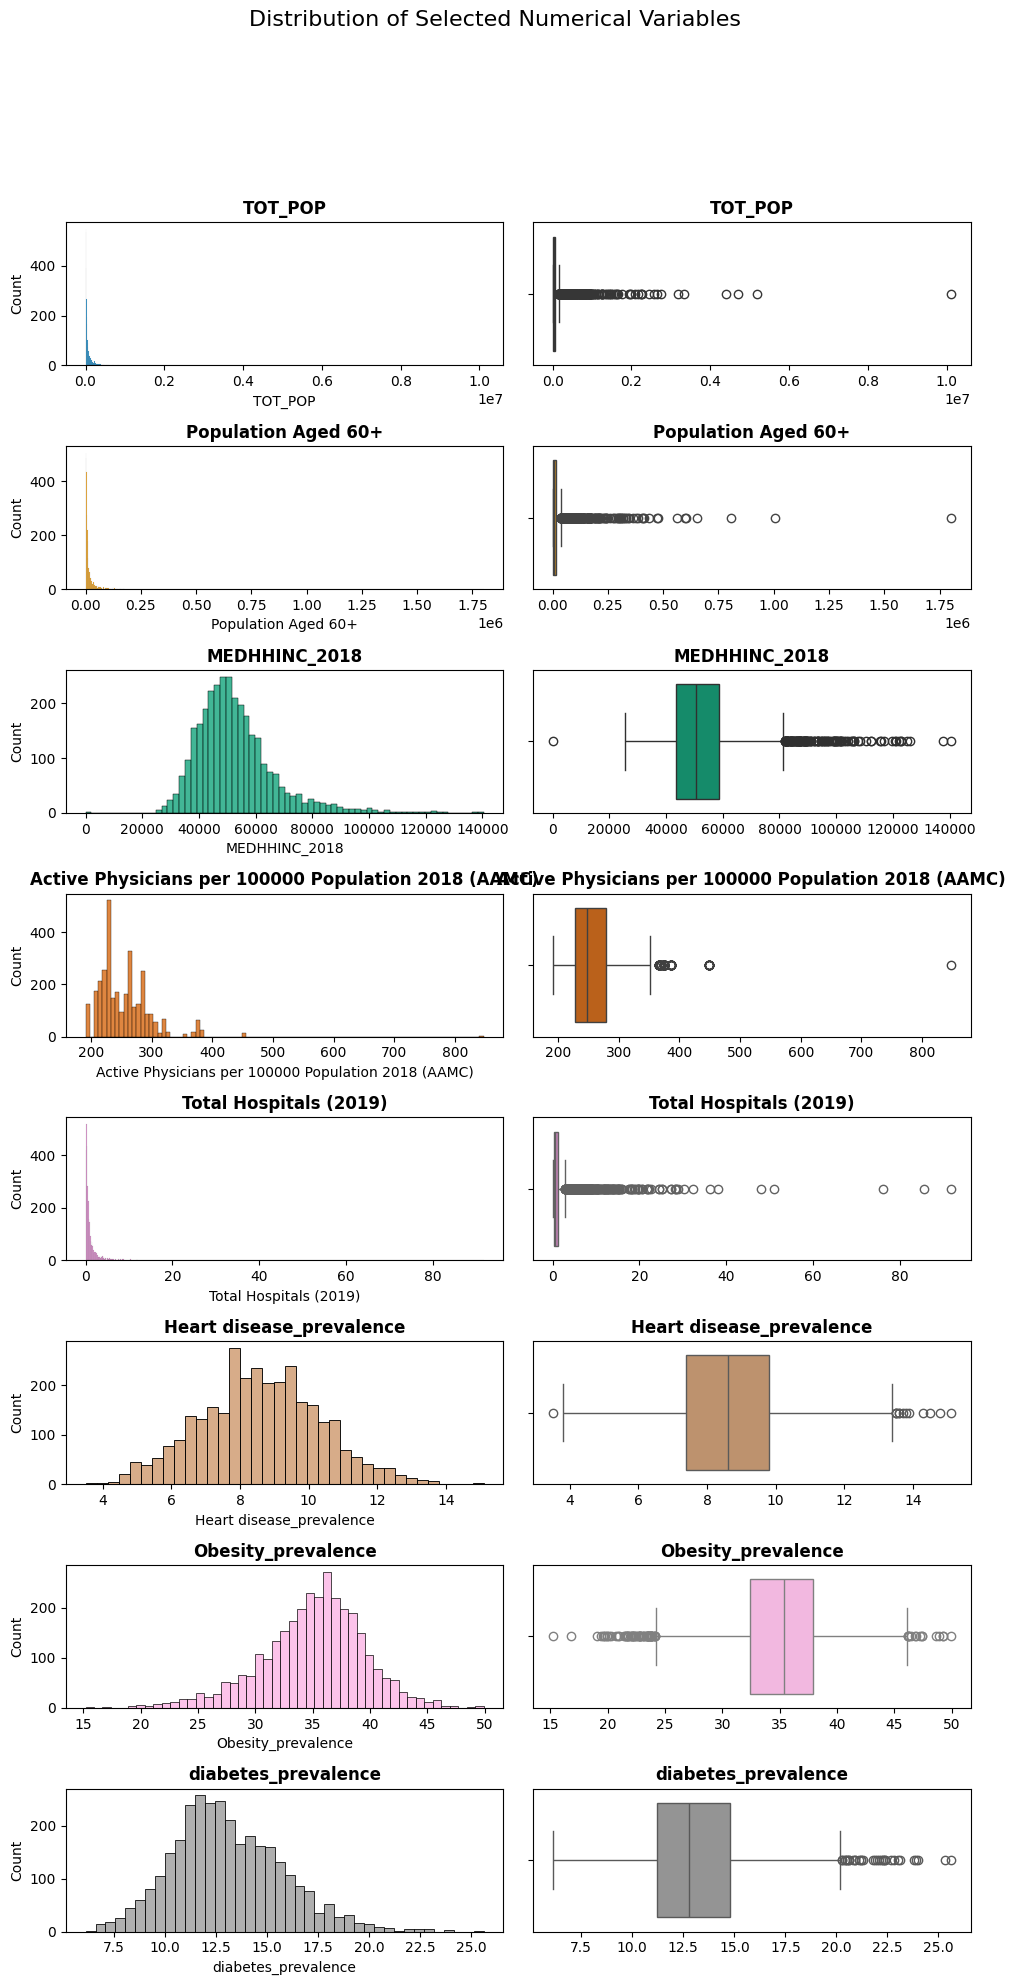

In [510]:
# List of variables chosen for analysis
selected_variables = [
    'TOT_POP',
    'Population Aged 60+',
    'MEDHHINC_2018',
    'Active Physicians per 100000 Population 2018 (AAMC)',
    'Total Hospitals (2019)',
    'Heart disease_prevalence',
    'Obesity_prevalence',
    'diabetes_prevalence'
    
]

df_numerical = df[selected_variables]

def plot_numerical_variables(df_numerical, hue=None): 
    """
    Plots histograms and boxplots for all numeric variables in `df_numerical`
    using a 2-column layout with a fixed color palette for visual consistency.

    Parameters:
    - df_numerical: DataFrame containing only the numerical columns to analyze.
    - hue: Column name for hue (optional). If provided, it must exist in `df_numerical`.
    """
  
    numerical_columns = df_numerical.columns.tolist()

  
    num_vars = len(numerical_columns)
    num_rows = (num_vars + 1) // 2  

   
    fig, axes = plt.subplots(num_rows * 2, 2, figsize=(10, num_rows * 5))
    plt.suptitle('Distribution of Selected Numerical Variables', fontsize=16, y=1.02)

   
    axes = axes.flatten()

   
    palette = sns.color_palette("colorblind", num_vars)

    # Loop to create histograms and boxplots for each numerical variable
    for i, col in enumerate(numerical_columns):
        color = palette[i % len(palette)]  
        
        # Histogram with or without hue
        sns.histplot(ax=axes[i * 2], data=df_numerical, x=col, hue=hue if hue in df_numerical.columns else None, color=color)
        axes[i * 2].set_title(col, fontweight='bold')  
        
        # Boxplot (without hue)
        sns.boxplot(ax=axes[i * 2 + 1], data=df_numerical, x=col, color=color)
        axes[i * 2 + 1].set_title(col, fontweight='bold')  
        axes[i * 2 + 1].set(xlabel=None)  


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_numerical_variables(df_numerical)


to have a better visualization of data distribution, I decided to graph a new version with a shorter limit in axis "x" of some features.

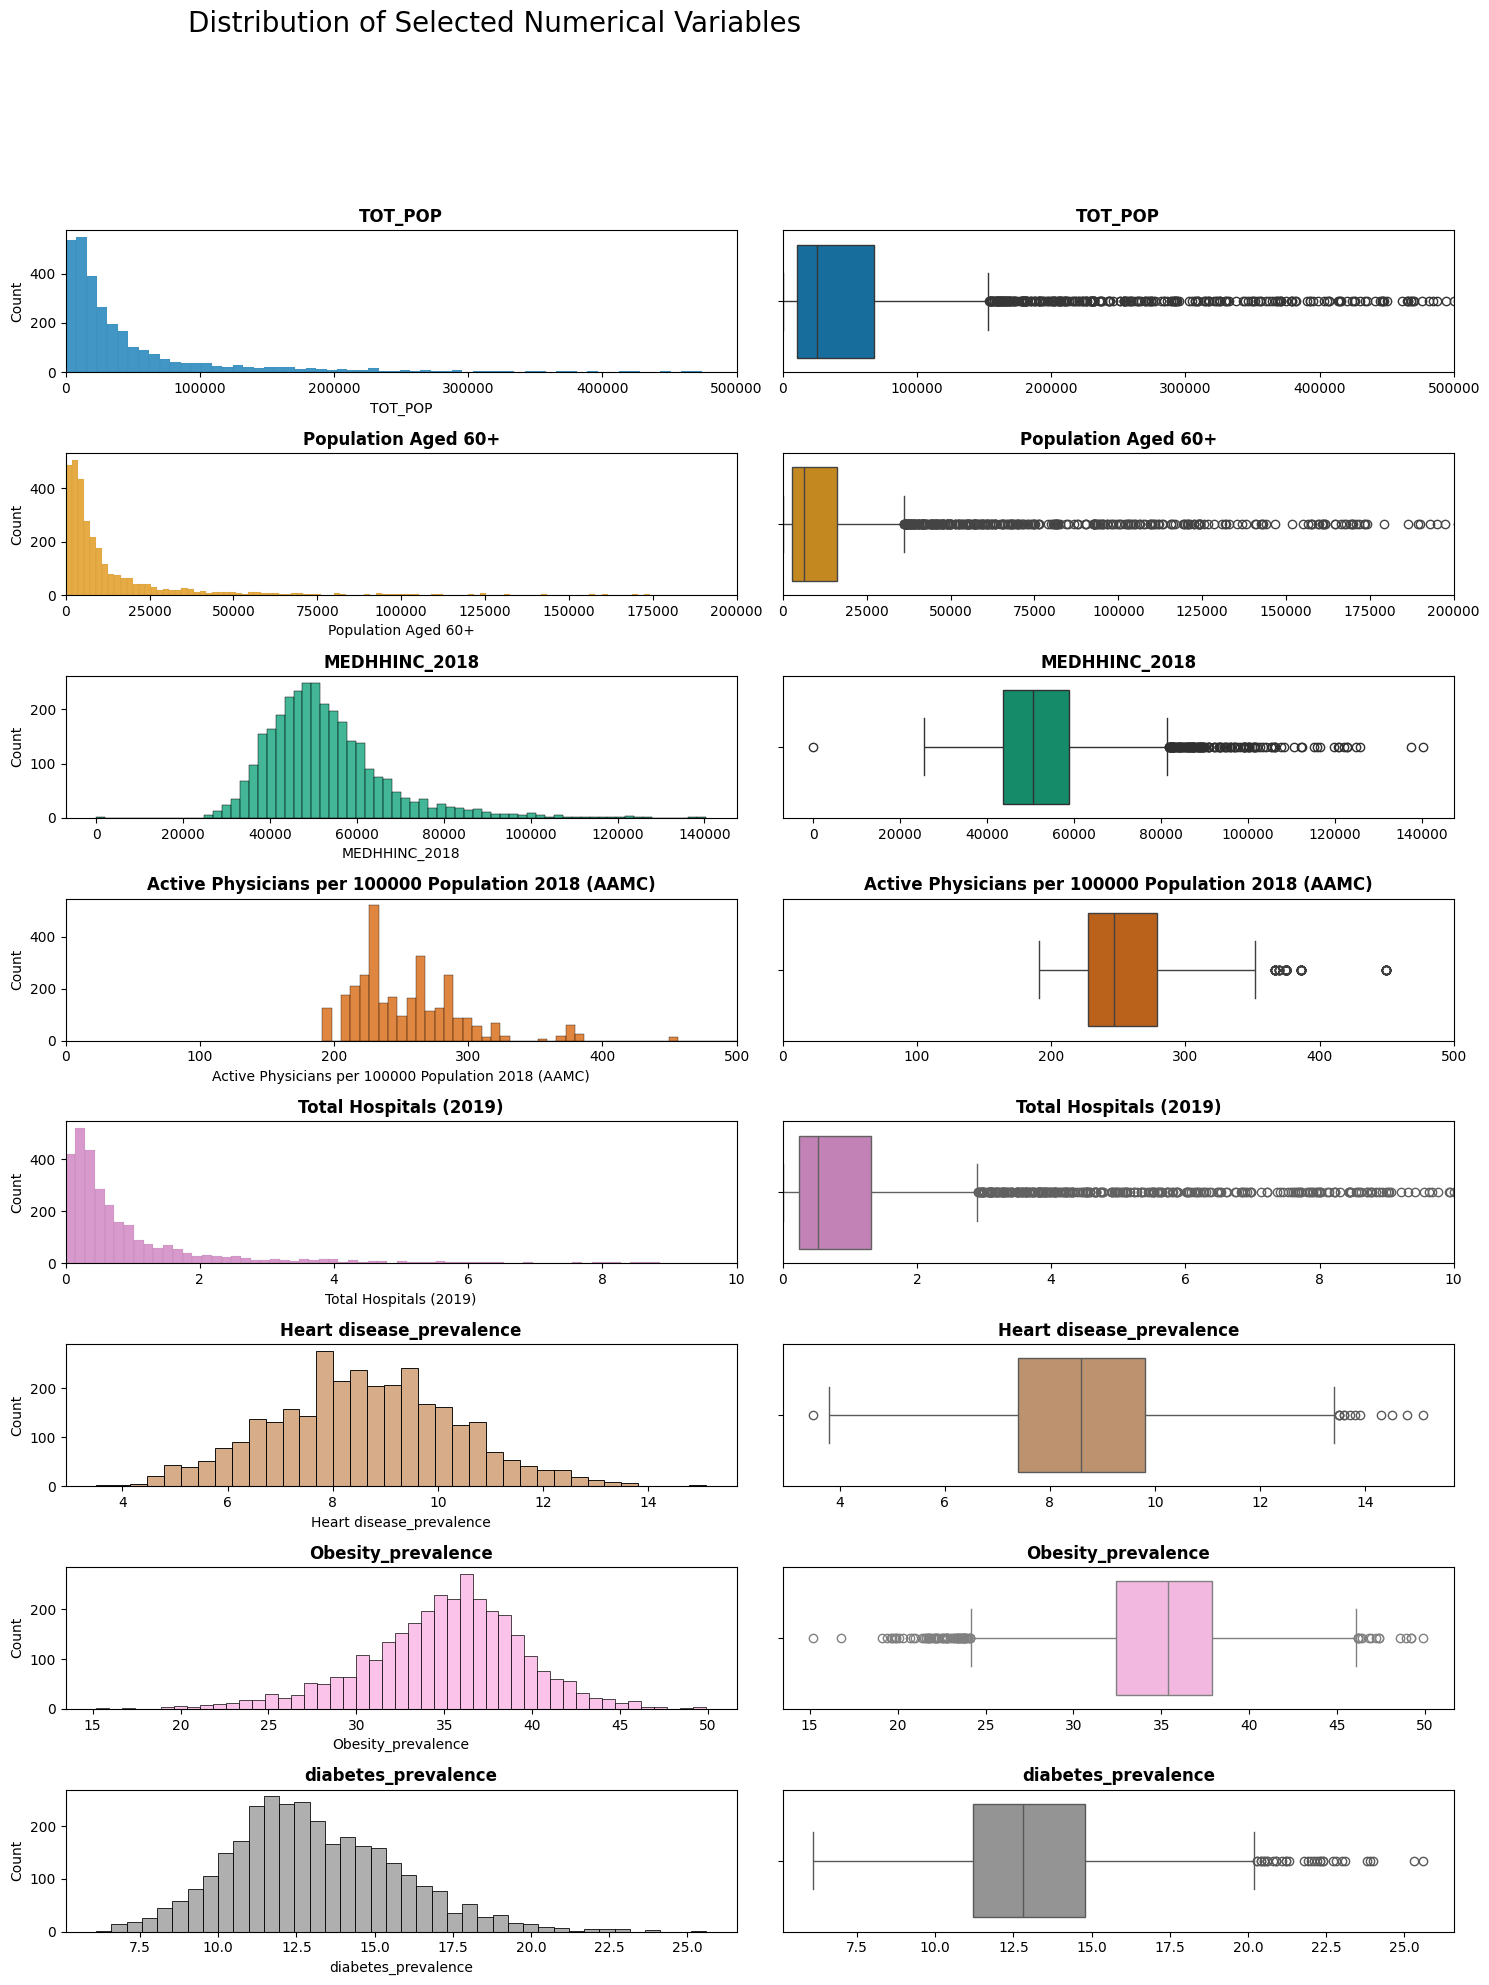

In [511]:
def plot_numerical_variables(df_numerical, hue=None): 
    
    # Set x-axis limits for specific variables
    x_limits = {
        'TOT_POP': (0, 500000),  
        'Population Aged 60+': (0, 200000),  
        'Active Physicians per 100000 Population 2018 (AAMC)': (0, 500),  
        'Total Hospitals (2019)': (0, 10)  
    }

   
    numerical_columns = df_numerical.columns.tolist()
    
    num_vars = len(numerical_columns)
    num_rows = (num_vars + 1) // 2  


    fig, axes = plt.subplots(num_rows * 2, 2, figsize=(10, num_rows * 5))
    plt.suptitle('Distribution of Selected Numerical Variables', fontsize=20, y=1.02)

    axes = axes.flatten()

   
    palette = sns.color_palette("colorblind", num_vars)

    # Loop to create histograms and boxplots for each numerical variable
    for i, col in enumerate(numerical_columns):
        color = palette[i % len(palette)]  
        
        # Histogram with or without hue
        sns.histplot(ax=axes[i * 2], data=df_numerical, x=col, hue=hue if hue in df_numerical.columns else None, color=color)
        axes[i * 2].set_title(col, fontweight='bold')  
        
        if col in x_limits:
            axes[i * 2].set_xlim(x_limits[col])

        # Boxplot (without hue)
        sns.boxplot(ax=axes[i * 2 + 1], data=df_numerical, x=col, color=color)
        axes[i * 2 + 1].set_title(col, fontweight='bold')  
        axes[i * 2 + 1].set(xlabel=None)  

        if col in x_limits:
            axes[i * 2 + 1].set_xlim(x_limits[col])

    plt.tight_layout(rect=[0, 0.03, 1.5, 0.95])
    plt.show()

plot_numerical_variables(df_numerical)


#### Statements

* `TOT_POP` and `Population Aged 60+`: Both variables are right-skewed, indicating that most counties have relatively small total and elderly populations. Counties with more elderly people may have higher risk of heart disease.

* `MEDHHINC_2018`: Median income is symmetric and clustered in the middle range, indicating economic disparities that may influence access to health care and the prevalence of heart disease.

* `Active Physicians per 100,000 Population` and `Total Hospitals`: The distribution is skewed, with most counties having fewer physicians and hospitals. Lower availability of health infrastructure may be associated with poorer management of chronic diseases.

* `Obesity_prevalence` and `diabetes_prevalence`: Both have distributions indicating significant rates of these conditions in most counties, suggesting that obesity and diabetes are widespread health problems and important risk factors for heart disease.

* `Heart disease_prevalence` (Target): The prevalence of heart disease is distributed symmetrically across counties, with the majority concentrated between 6% and 12%. This variable will be analyzed in relation to the other factors to understand associations and patterns.

**Choosing `heart disease_prevalence` as the target variable** provides a focused and practical approach to understanding the relationships between sociodemographic factors, healthcare infrastructure, and chronic health conditions such as obesity and diabetes. These factors are known to be closely linked to heart disease, increasing the risk and complexity of the condition. By investigating the determinants of heart disease prevalence, including factors that may contribute to obesity and diabetes, this study seeks to generate insights that can inform public health policymaking, improve the allocation of healthcare resources, and contribute to prevention strategies that address key risk factors for heart disease. In this way, the study not only sheds light on the specific factors for heart disease, but also considers the interrelationships with other health conditions that broadly affect the population.

**STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES**

Multivariate analysis also allows combining the class with several predictors at the same time to enrich the analysis.

 ##### ENCODING CATEGORICAL VALUES: FROM STRING TO NUMERICAL TRANSFORMATION -> JSON SAVING

In [512]:
df_n = df.copy()

In [513]:
os.makedirs('../data/interim/enc/', exist_ok=True)

for col in df_categorical.columns:
    # Get unique values and create an encoding dictionary
    unique_values = list(df_categorical[col].unique())
    encoder_dict = dict(zip(unique_values, range(len(unique_values))))
    
    # Save the encoding dictionary as a JSON file
    with open(f'../data/interim/enc/{col}_n.json', 'w') as f:
        json.dump(encoder_dict, f)

# Load and apply the encoding from JSON files
for col in df_categorical.columns:
    # Load the encoder dictionary from the saved JSON file
    encoder_dict = json.load(open(f'../data/interim/enc/{col}_n.json'))
    
    # Apply the mapping to the column in the DataFrame
    df_n[col] = df_n[col].map(encoder_dict)

In [514]:
df_n.head()


,TOT_POP,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence
0,55601,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,10552,10291,19.3,19.5,59338,217.1,1.148905,10523,0,0,35.8,7.9,12.9
1,218022,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,46025,46075,13.9,13.1,57588,217.1,4.505074,53519,1,0,29.7,7.8,12.0
2,24881,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,4566,2220,43.9,36.7,34382,217.1,0.514126,6150,2,0,40.7,11.0,19.7
3,22400,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,3846,1813,27.8,26.3,46064,217.1,0.462860,4773,3,0,38.7,8.6,14.1
4,57840,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,13267,5010,18.0,15.5,50412,217.1,1.195171,13600,4,0,34.0,9.2,13.5


**4.1 NUMERICAL-NUMERICAL ANALYSIS**

In this section, we investigate the relationships between the target variable, Heart disease_prevalence, and other numerical variables, seeking to identify correlations and patterns that may help to understand the determinants of heart disease prevalence.

- **Demographics:** Is there a correlation between total population size (TOT_POP) or the proportion of elderly people (Population Aged 60+) and the prevalence of heart disease?

- **Socioeconomics:** Do counties with higher median income (MEDHHINC_2018) have lower rates of heart disease?

- **Healthcare Infrastructure:** Are physician density (Active Physicians per 100,000 Population) and number of hospitals (Total Hospitals) associated with lower rates of heart disease?

- **Chronic Conditions:** Are obesity (Obesity_prevalence) and diabetes (diabetes_prevalence) relevant predictors of heart disease prevalence?

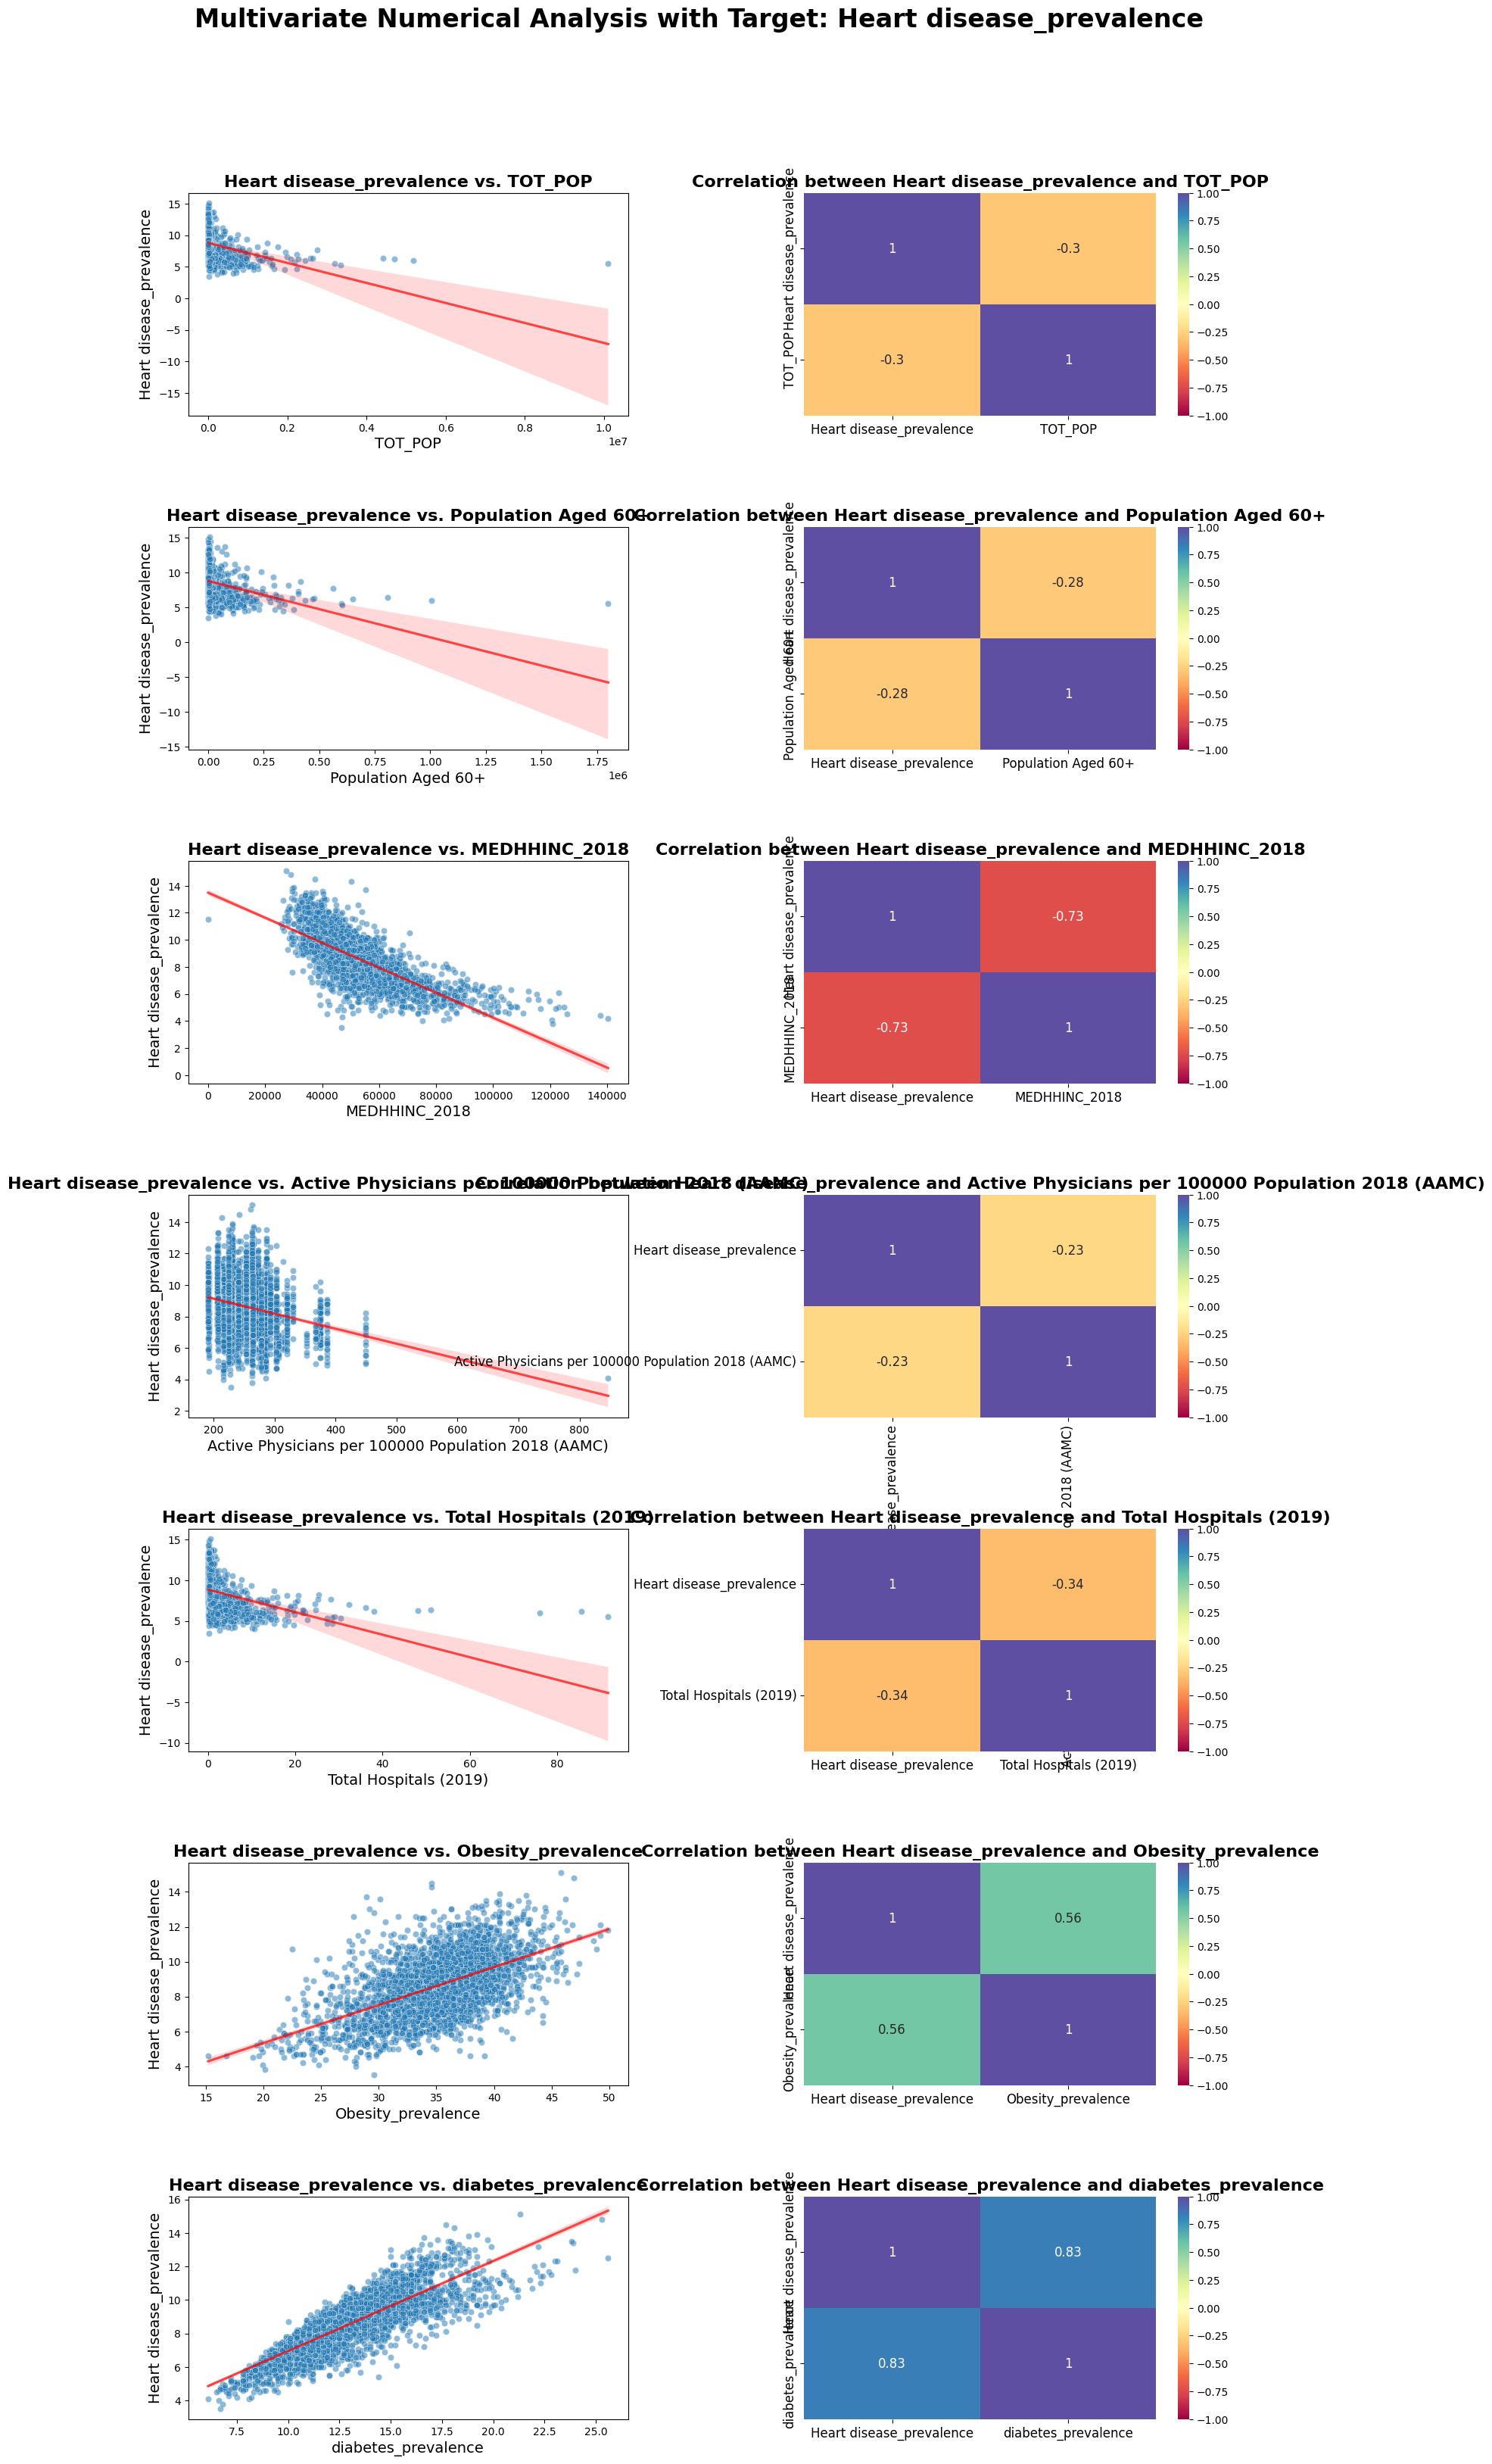

In [515]:
def multivariate_numeric_analysis(df, target_variable, numerical_columns):
    """
    Generates scatter plots and correlation matrices between the target variable and other numerical variables.

    Parameters:
    - df: DataFrame containing the data.
    - target_variable: String representing the name of the target variable (must be in numerical format).
    - numerical_columns: List of strings with the names of the numerical columns for analysis.
    """
   
    num_vars = len(numerical_columns)
    fig, axes = plt.subplots(num_vars, 2, figsize=(18, num_vars * 5))
    fig.suptitle(f'Multivariate Numerical Analysis with Target: {target_variable}', fontsize=24, fontweight='bold', y=1.02)
    
  
    for i, col in enumerate(numerical_columns):
        # Scatterplot with regression line
        sns.scatterplot(ax=axes[i, 0], data=df, x=col, y=target_variable, alpha=0.5)
        sns.regplot(ax=axes[i, 0], data=df, x=col, y=target_variable, scatter=False, color='red', line_kws={"alpha":0.7})
        axes[i, 0].set_title(f'{target_variable} vs. {col}', fontsize=16, fontweight='bold')
        axes[i, 0].set_xlabel(col, fontsize=14)
        axes[i, 0].set_ylabel(target_variable, fontsize=14)
        
        # Correlation matrix between the target variable and the numerical variable
        corr_data = df[[target_variable, col]].corr()
        sns.heatmap(ax=axes[i, 1], data=corr_data, annot=True, cmap='Spectral', cbar=True, vmin=-1, vmax=1, annot_kws={"size": 12})
        axes[i, 1].set_title(f'Correlation between {target_variable} and {col}', fontsize=16, fontweight='bold')
        axes[i, 1].tick_params(axis='both', which='major', labelsize=12)


    plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.4)
    plt.show()

numerical_columns = [
    'TOT_POP', 'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Obesity_prevalence', 
    'diabetes_prevalence'
]
target_variable = 'Heart disease_prevalence'
multivariate_numeric_analysis(df_n, target_variable, numerical_columns)



#### Statements

**Heart disease_prevalence vs. TOT_POP**

* There is a moderate negative correlation of -0.3 between TOT_POP and Heart disease_prevalence.

* In more populated areas, the prevalence of heart disease tends to be lower. This may indicate better living conditions, greater access to health care, or better public health policies in more densely populated areas.

**Heart disease_prevalence vs. Population Aged 60+**

* The correlation is -0.28, indicating a weak negative relationship between the elderly population and the prevalence of heart disease.

* Surprisingly, counties with a larger elderly population do not necessarily have a higher prevalence of heart disease, suggesting that other factors (such as health care infrastructure and socioeconomic factors) may play a more significant role.

**Heart disease_prevalence vs. MEDHHINC_2018 (Median Household Income)**

* There is a strong negative correlation of -0.73 between MEDHHINC_2018 and Heart disease_prevalence.

* Counties with higher median income tend to have a lower prevalence of heart disease. The relationship indicates that better economic conditions and, possibly, better access to health care and education contribute to the reduction in the prevalence of heart disease.

**Heart disease_prevalence vs. Active Physicians per 100,000 Population 2018 (AAMC)**

* The correlation is -0.23, indicating a slight negative relationship between physician density and heart disease prevalence.

* Although the correlation is weak, the presence of more physicians per 100 000 population may be associated with a slight reduction in heart disease prevalence, reflecting better access to preventive medical care and treatments.

**Heart disease_prevalence vs. Total Hospitals (2019)**

* There is a negative correlation of -0.34 between the total number of hospitals and the prevalence of heart disease.

* The presence of more hospitals in a county is associated with a lower prevalence of heart disease, suggesting that a more robust health care infrastructure contributes to more effective prevention and treatment of heart conditions.

**Heart disease_prevalence vs. Obesity_prevalence**

* The correlation is 0.56, indicating a moderate positive correlation between obesity and the prevalence of heart disease.

* Obesity is a significant risk factor for heart disease, and this moderate relationship suggests that counties with a higher prevalence of obesity also have a higher prevalence of heart disease.

**Heart disease_prevalence vs. diabetes_prevalence**
* There is a strong positive correlation of 0.83 between the prevalence of diabetes and the prevalence of heart disease.
* Diabetes is one of the strongest risk factors for heart disease. The strong positive relationship indicates that counties with a high prevalence of diabetes tend to also have a high prevalence of heart disease, reinforcing the need to address diabetes as part of heart disease prevention strategies.


**4.2 CATEGORICAL-CATEGORICAL ANALYSIS**

I chose not to plot categorical-categorical graphs, as the available categorical variables (`COUNTY_NAME` and `STATE_NAME`) are simply geographic identifiers and do not provide direct insights into the factors associated with the prevalence of heart disease. Instead, I decided to move towards an analysis with a numerical-categorical correlation matrix, allowing me to explore quantitative relationships with demographic and health factors that influence the disease.

**4.3 CORRELATION MATRIX: NUMERICAL-CATEGORICAL (complete)**

In [516]:
print(df_n[['COUNTY_NAME', 'STATE_NAME']].dtypes)


COUNTY_NAME    int64
STATE_NAME     int64
dtype: object


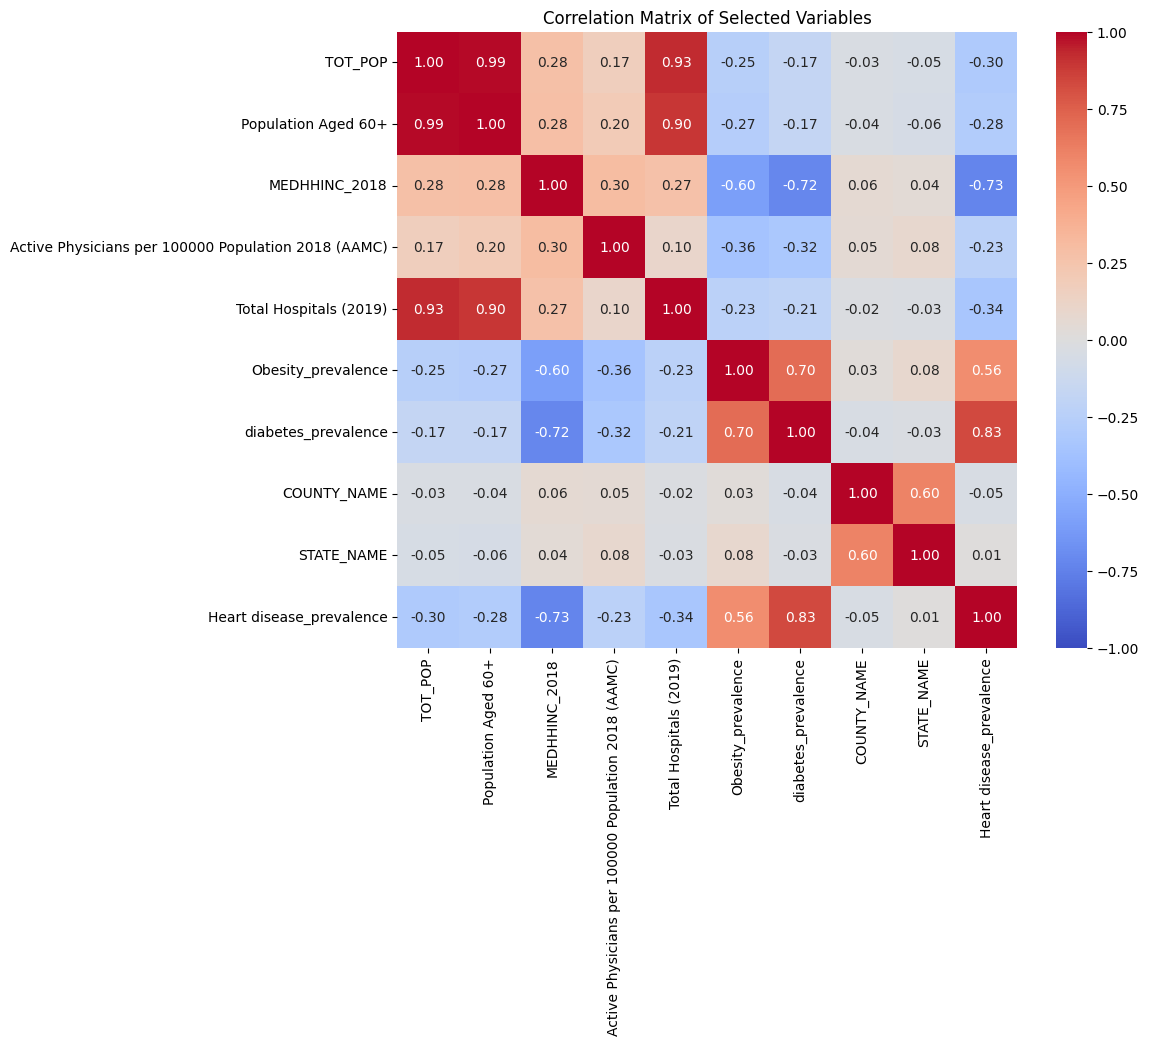

In [517]:
selected_variables = [
    'TOT_POP', 'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Obesity_prevalence', 
    'diabetes_prevalence', 'COUNTY_NAME', 'STATE_NAME', 'Heart disease_prevalence'
]

df_selected = df_n[selected_variables]

correlation_matrix = df_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()



#### Statements

**Household income (`MEDHHINC_2018`)**: Strong negative correlation with `Heart disease_prevalence` (-0.73), suggesting that counties with higher median income tend to have lower prevalence of heart disease.

**Diabetes (`diabetes_prevalence`)**: Strong positive correlation (0.83) with heart disease, indicating diabetes as an important risk factor.

**Obesity (`Obesity_prevalence`)**: Moderate positive correlation (0.56), highlighting the role of excess weight in heart disease.

**Healthcare Infrastructure**: Moderate negative correlations with `Total Hospitals` (-0.34) and `Active Physicians per 100000` (-0.23), suggesting that greater access to health care is associated with lower prevalence of heart disease.

**STEP 5. FEATURE ENGINEERING**

**5.1 OUTLIER ANALYSIS**

In [518]:
df_stats = df_n.describe()
df_stats

,TOT_POP,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence
count,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,1.041894e+05,1.191621e+04,7220.310510,4035.541720,7.965979e+04,84.494109,1.395026e+04,9.342405,1320.231210,2.344741,6.155618e+03,1.554548,254.561783,0.141007,2848.954140,2.123190,2.017919e+04,2.193144e+04,21.106911,19.882962,52767.083758,254.923567,1.655299,2.132298e+04,688.478981,26.253503,35.019299,8.607803,13.073503
std,3.335834e+05,3.451858e+04,20287.498429,12063.782251,2.372880e+05,16.348987,5.899787e+04,14.478294,5362.395724,7.721990,4.388798e+04,2.857088,2192.079705,0.967946,11083.924606,1.544463,6.086391e+04,7.977484e+04,8.909328,8.778545,13907.992668,42.291759,4.293436,6.140588e+04,541.767733,14.260381,4.517088,1.758587,2.724351
min,8.800000e+01,2.000000e+01,6.000000,0.000000,2.400000e+01,3.841985,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,191.300000,0.001363,2.700000e+01,0.000000,0.000000,15.200000,3.500000,6.100000
25%,1.096325e+04,1.476500e+03,950.750000,533.000000,9.008750e+03,79.620473,1.420000e+02,0.867069,73.000000,0.384294,5.700000e+01,0.465659,5.000000,0.031896,180.000000,1.357557,2.295250e+03,1.201750e+03,14.500000,13.400000,43677.000000,227.600000,0.248797,2.814750e+03,182.000000,14.000000,32.400000,7.400000,11.200000
50%,2.580050e+04,3.410000e+03,2177.000000,1160.000000,2.206900e+04,91.410189,9.050000e+02,2.545440,199.000000,0.641143,1.770000e+02,0.739372,16.000000,0.062024,437.500000,1.789720,5.325500e+03,3.168000e+03,20.100000,18.800000,50564.500000,247.100000,0.524404,6.310000e+03,564.000000,25.000000,35.400000,8.600000,12.800000
75%,6.791300e+04,8.710500e+03,5574.000000,2899.750000,5.898575e+04,95.521727,5.765000e+03,10.852053,666.000000,1.331416,8.662500e+02,1.433411,69.000000,0.118429,1497.000000,2.409970,1.441225e+04,1.049675e+04,26.300000,24.900000,58822.250000,278.800000,1.311585,1.610625e+04,1129.250000,40.000000,37.900000,9.800000,14.800000
max,1.010552e+07,1.014325e+06,572530.000000,356275.000000,7.151444e+06,99.043785,1.236170e+06,86.069762,145254.000000,92.515200,1.551894e+06,42.952310,94079.000000,48.863636,313259.000000,30.304056,1.790808e+06,2.177481e+06,68.300000,66.500000,140382.000000,847.000000,91.712638,1.800341e+06,1840.000000,50.000000,49.900000,15.100000,25.600000


In [519]:
outlier_variables = [
    # Variables for creating new features
    '60-69', '70-79', '80+', 'TOT_POP', 
    '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
    '% Hawaiian/PI-alone', '% Two or more races', 
    "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
    'Black-alone pop', 'Native American/American Indian-alone pop', 
    'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 
    'Two or more races pop', 'PCTPOV017_2018', 'PCTPOV517_2018',
    
    # Variables selected for analysis
    'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Heart disease_prevalence', 
    'Obesity_prevalence', 'diabetes_prevalence'
]


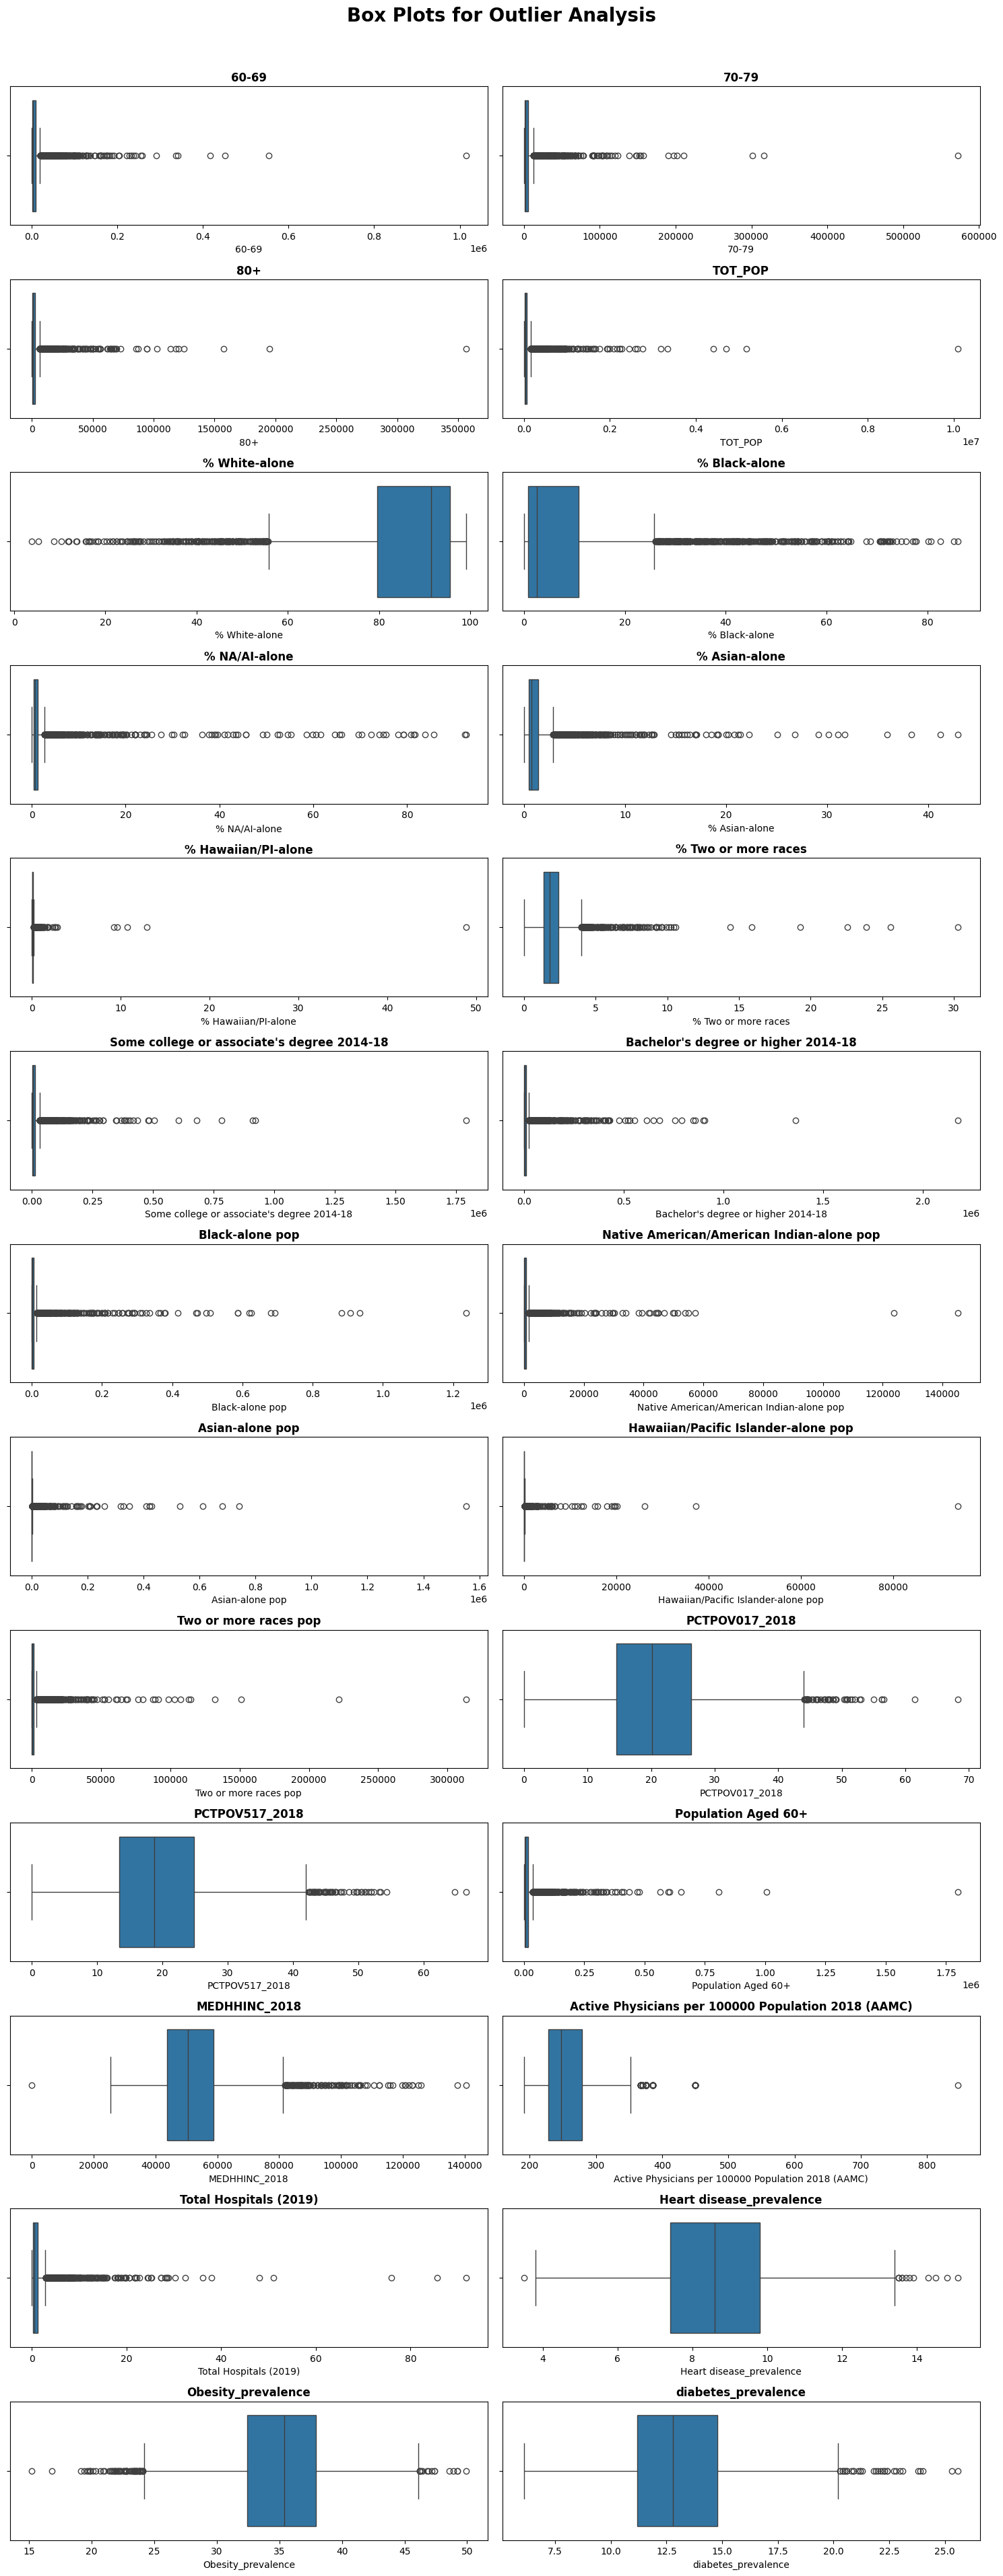

In [520]:
num_vars = len(outlier_variables)
num_rows = math.ceil(num_vars / 2)  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 3))
fig.suptitle('Box Plots for Outlier Analysis', fontsize=20, fontweight='bold')


for i, var in enumerate(outlier_variables):
    row, col = divmod(i, 2)  
    sns.boxplot(ax=axes[row, col], data=df_n, x=var)
    axes[row, col].set_title(var, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



#### Statements

In [521]:
df_with_outliers = df_n.copy()

In [522]:
df_without_outliers = df_n.copy()

In [523]:

def remove_outliers(x, feature_name, allow_neg=True):
 
    safe_feature_name = feature_name.replace("%", "percent").replace("/", "_").replace(" ", "_")

    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr * 1.5)
    lower_lim = q1 - (iqr * 1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda val: upper_lim if val > upper_lim else (lower_lim if val < lower_lim else val))


    filename = f'../data/interim/outliers_lims_{safe_feature_name}.json'
    with open(filename, 'w') as f:
        json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, f)

    return x


In [524]:
outlier_variables = [
    'TOT_POP',
    '60-69', '70-79', '80+',
    '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
    '% Hawaiian/PI-alone', '% Two or more races',
    "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
    'PCTPOV017_2018', 'PCTPOV517_2018',
    'MEDHHINC_2018',
    'Active Physicians per 100000 Population 2018 (AAMC)',
    'Total Hospitals (2019)'
]


for feature in outlier_variables:
    df_without_outliers[feature] = remove_outliers(df_without_outliers[feature], feature_name=feature, allow_neg=False)

In [525]:
df_with_outliers.head()

,TOT_POP,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence
0,55601,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,10552,10291,19.3,19.5,59338,217.1,1.148905,10523,0,0,35.8,7.9,12.9
1,218022,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,46025,46075,13.9,13.1,57588,217.1,4.505074,53519,1,0,29.7,7.8,12.0
2,24881,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,4566,2220,43.9,36.7,34382,217.1,0.514126,6150,2,0,40.7,11.0,19.7
3,22400,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,3846,1813,27.8,26.3,46064,217.1,0.462860,4773,3,0,38.7,8.6,14.1
4,57840,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,13267,5010,18.0,15.5,50412,217.1,1.195171,13600,4,0,34.0,9.2,13.5


In [526]:
df_without_outliers.head()

,TOT_POP,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence
0,55601.000,5826.0,4050.000,2014.000,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,10552.00,10291.00,19.3,19.5,59338.0,217.1,1.148905,10523,0,0,35.8,7.9,12.9
1,153337.625,19561.5,12508.875,6449.875,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,32587.75,24439.25,13.9,13.1,57588.0,217.1,2.905768,53519,1,0,29.7,7.8,12.0
2,24881.000,3076.0,2244.000,1048.000,12209,55.768592,12042,25.829529,164,0.659137,113,0.454162,46,0.184880,307,1.233873,4566.00,2220.00,43.9,36.7,34382.0,217.1,0.514126,6150,2,0,40.7,11.0,19.7
3,22400.000,2545.0,1723.000,785.000,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,3846.00,1813.00,27.8,26.3,46064.0,217.1,0.462860,4773,3,0,38.7,8.6,14.1
4,57840.000,6965.0,4931.000,2335.000,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,13267.00,5010.00,18.0,15.5,50412.0,217.1,1.195171,13600,4,0,34.0,9.2,13.5


**5.2 MISSING VALUES**

In [527]:
df_without_outliers.isna().sum()[df_with_outliers.isna().sum()>0]

Series([], dtype: int64)

In [528]:
df_with_outliers.isna().sum()[df_with_outliers.isna().sum()>0]

Series([], dtype: int64)

#### Statements

* There are no missing values for treatment.

**5.3 INFERENCE OF NEW FEATURES**

**New Variable:** `Percent_Pop_Aged_60_plus`

In [529]:
df['Percent_Pop_Aged_60_plus'] = (df['60-69'] + df['70-79'] + df['80+']) / df['TOT_POP'] * 100

**New Variable:** `Racial_Diversity_Index`

In [530]:
df['Racial_Diversity_Index'] = (df[['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
                                    '% Hawaiian/PI-alone', '% Two or more races']] > 5).sum(axis=1)

**New Variable**: `Percent_Higher_Education`

In [531]:
df['Percent_Higher_Education'] = (df["Some college or associate's degree 2014-18"] + 
                                  df["Bachelor's degree or higher 2014-18"]) / df['TOT_POP'] * 100

**New Variable**: `Minority_Population`

In [532]:
df['Minority_Population'] = (df['Black-alone pop'] + df['Native American/American Indian-alone pop'] +
                             df['Asian-alone pop'] + df['Hawaiian/Pacific Islander-alone pop'] + 
                             df['Two or more races pop'])

**New Variable**: `Child_Poverty_Index`

In [533]:
df['Child_Poverty_Index'] = (df['PCTPOV017_2018'] + df['PCTPOV517_2018']) / 2

In [534]:

def add_and_drop_features(df):
   
    df['Percent_Pop_Aged_60_plus'] = (df['60-69'] + df['70-79'] + df['80+']) / df['TOT_POP'] * 100
    df['Racial_Diversity_Index'] = (df[['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
                                        '% Hawaiian/PI-alone', '% Two or more races']] > 5).sum(axis=1)
    df['Percent_Higher_Education'] = (df["Some college or associate's degree 2014-18"] + 
                                      df["Bachelor's degree or higher 2014-18"]) / df['TOT_POP'] * 100
    df['Minority_Population'] = (df['Black-alone pop'] + df['Native American/American Indian-alone pop'] +
                                 df['Asian-alone pop'] + df['Hawaiian/Pacific Islander-alone pop'] + 
                                 df['Two or more races pop'])
    df['Child_Poverty_Index'] = (df['PCTPOV017_2018'] + df['PCTPOV517_2018']) / 2

    
    columns_to_drop = [
        '60-69', '70-79', '80+', '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
        '% Hawaiian/PI-alone', '% Two or more races', "Some college or associate's degree 2014-18", 
        "Bachelor's degree or higher 2014-18", 'Black-alone pop', 'Native American/American Indian-alone pop', 
        'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop', 'PCTPOV017_2018', 
        'PCTPOV517_2018'
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    return df


df_with_outliers = add_and_drop_features(df_with_outliers)
df_without_outliers = add_and_drop_features(df_without_outliers)



In [535]:
df_with_outliers.head()

,TOT_POP,White-alone pop,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
0,55601,42660,59338,217.1,1.148905,10523,0,0,35.8,7.9,12.9,21.384507,2,37.486736,12941,19.40
1,218022,190301,57588,217.1,4.505074,53519,1,0,29.7,7.8,12.0,27.628404,2,42.243443,27721,13.50
2,24881,12209,34382,217.1,0.514126,6150,2,0,40.7,11.0,19.7,25.593827,2,27.273823,12672,40.30
3,22400,17211,46064,217.1,0.462860,4773,3,0,38.7,8.6,14.1,22.558036,2,25.263393,5189,27.05
4,57840,55456,50412,217.1,1.195171,13600,4,0,34.0,9.2,13.5,24.604080,1,31.599239,2384,16.75


In [536]:
df_without_outliers.head()

,TOT_POP,White-alone pop,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,Heart disease_prevalence,diabetes_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
0,55601.000,42660,59338.0,217.1,1.148905,10523,0,0,35.8,7.9,12.9,21.384507,2,37.486736,12941,19.40
1,153337.625,190301,57588.0,217.1,2.905768,53519,1,0,29.7,7.8,12.0,25.121199,2,37.190481,27721,13.50
2,24881.000,12209,34382.0,217.1,0.514126,6150,2,0,40.7,11.0,19.7,25.593827,2,27.273823,12672,40.30
3,22400.000,17211,46064.0,217.1,0.462860,4773,3,0,38.7,8.6,14.1,22.558036,2,25.263393,5189,27.05
4,57840.000,55456,50412.0,217.1,1.195171,13600,4,0,34.0,9.2,13.5,24.604080,1,31.599239,2384,16.75


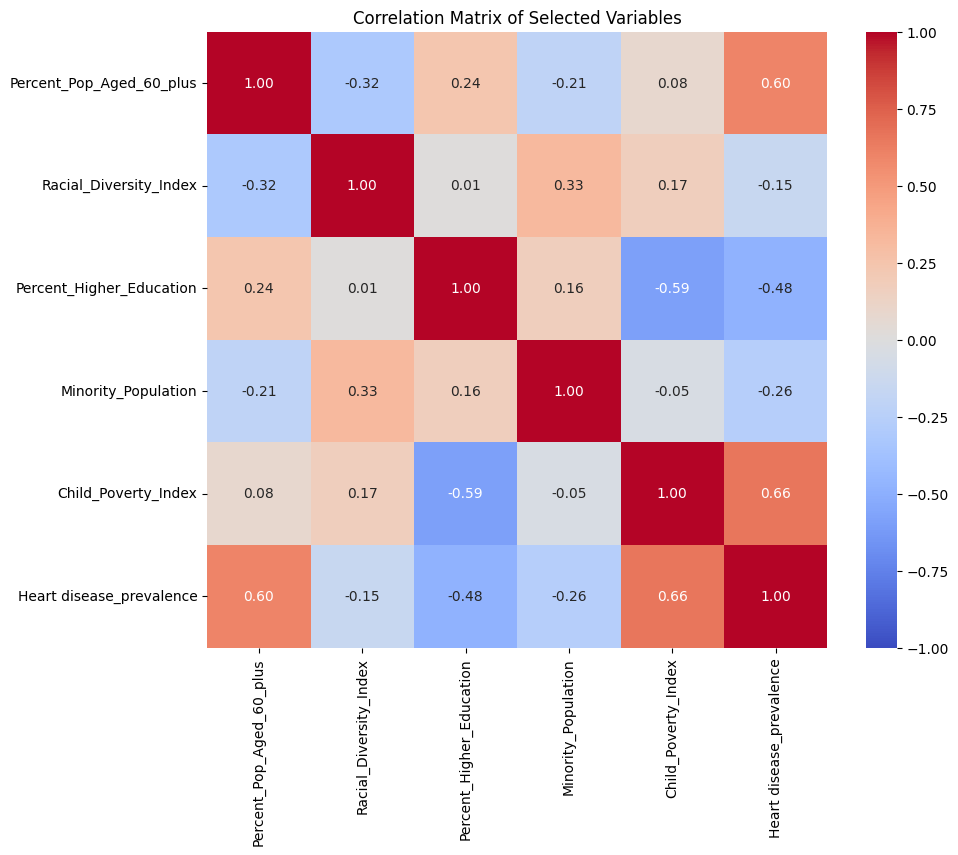

In [537]:
new_features = ['Percent_Pop_Aged_60_plus', 'Racial_Diversity_Index', 'Percent_Higher_Education', 'Minority_Population', 'Child_Poverty_Index', 'Heart disease_prevalence']

df_selected = df_with_outliers[new_features]

correlation_matrix = df_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

**Percent_Pop_Aged_60_plus:** Shows a moderate positive correlation with `Heart disease_prevalence` (0.60), suggesting that an older population is associated with a higher prevalence of heart disease, consistent with the fact that age is a significant risk factor for cardiovascular disease.

**Child_Poverty_Index:** Also shows a moderate positive correlation with `Heart disease_prevalence` (0.66). This indicates that high rates of childhood poverty may be associated with a higher prevalence of heart disease, possibly due to socioeconomic inequalities and access to health care.

**Percent_Higher_Education:** Shows a negative correlation with `Heart disease_prevalence` (-0.48), suggesting that regions with a more educated population may have a lower prevalence of heart disease. Education may be associated with healthier behaviors and better access to preventive care.

**Racial_Diversity_Index** and **Minority_Population:** Both have low correlations with `Heart disease_prevalence` (-0.15 and -0.26, respectively), indicating that racial diversity and minority status have a less direct impact on heart disease prevalence compared to other factors.

These results suggest that factors such as age, education level, and childhood poverty play a more significant role in heart disease prevalence at the population level, which may inform health policy and resource allocation strategies in more vulnerable areas.

**5.4 SPLI TRAIN/TEST OF 2 DATAFRAMES: WITH AND WITHOUT OUTLIERS**

In [538]:
def split(target, df, test_size=0.2, random_state=123):
    """
    Splits a DataFrame into training and testing sets.

    Parameters:
    - target: str, the name of the target column to be predicted
    - df: DataFrame, the complete DataFrame to split
    - test_size: float, proportion of the data to allocate to the test set (default is 0.2)
    - random_state: int, sets the seed for reproducibility (default is 123)

    Returns:
    - X_train, X_test: DataFrames containing the training and testing features
    - y_train, y_test: Series containing the training and testing target values
    """
    
    X = df.drop(columns=target)  
    y = df[target]               

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [539]:
# Split original dataframe 
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('Heart disease_prevalence', df_with_outliers)
X_train_without_outliers, X_test_without_outliers, _, _ = split('Heart disease_prevalence', df_without_outliers)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [540]:
# View train and test data for verification
X_train_with_outliers.head()

,TOT_POP,White-alone pop,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,diabetes_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
2295,142067,133931,48809,320.5,2.207480,38502,1401,38,35.6,12.4,27.729170,1,31.002977,8136,14.85
1901,82029,75240,43328,255.0,0.884783,20816,701,33,37.1,14.0,27.069695,2,33.817309,6789,21.35
3023,24842,24219,38572,263.4,0.770366,7413,733,48,39.1,15.6,30.025763,1,27.827872,623,25.10
779,31280,30227,51487,230.8,0.617011,8461,532,14,31.9,13.2,27.973146,1,31.812660,1053,16.55
822,6993,6783,54658,218.2,0.261450,2030,244,15,37.0,11.6,31.059631,1,40.354640,210,16.00


In [541]:
X_train_without_outliers.head()

,TOT_POP,White-alone pop,MEDHHINC_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),Population Aged 60+,COUNTY_NAME,STATE_NAME,Obesity_prevalence,diabetes_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
2295,142067.0,133931,48809.0,320.5,2.207480,38502,1401,38,35.6,12.4,26.816133,1,31.002977,8136,14.85
1901,82029.0,75240,43328.0,255.0,0.884783,20816,701,33,37.1,14.0,27.069695,2,33.817309,6789,21.35
3023,24842.0,24219,38572.0,263.4,0.770366,7413,733,48,39.1,15.6,30.025763,1,27.827872,623,25.10
779,31280.0,30227,51487.0,230.8,0.617011,8461,532,14,31.9,13.2,27.973146,1,31.812660,1053,16.55
822,6993.0,6783,54658.0,218.2,0.261450,2030,244,15,37.0,11.6,31.059631,1,40.354640,210,16.00


**5.5 NORMALIZATION**

In [542]:
def normalize_and_save(X_train, X_test, filename):
    """
    Normalizes the data using StandardScaler and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_norm: DataFrame with the normalized training data
    - X_test_norm: DataFrame with the normalized testing data
    """

    # Initialize and adjusts the scaler
    scaler = StandardScaler()
    scaler.fit(X_train)  

    # Apply normalization to training and testing data
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    # Save the scaler for future use
    joblib.dump(scaler, f'../data/processed/{filename}.sav')

    return X_train_norm, X_test_norm

# Application of the function to normalize data with and without outliers
X_train_with_outliers_norm, X_test_with_outliers_norm = normalize_and_save(
    X_train_with_outliers, X_test_with_outliers, 'normalized_with_outliers'
)

X_train_without_outliers_norm, X_test_without_outliers_norm = normalize_and_save(
    X_train_without_outliers, X_test_without_outliers, 'normalized_without_outliers'
)

**5.6 min-MAX SCALING**

In [543]:
def minmax_and_save(X_train, X_test, filename):
    """
    Applies Min-Max Scaling to the data and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_minmax: DataFrame with the scaled training data
    - X_test_minmax: DataFrame with the scaled testing data
    """

    scaler = MinMaxScaler()
    scaler.fit(X_train) 

    # Apply Min-Max Scaling to training and testing data
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index=X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index=X_test.index, columns=X_test.columns)

    # Save the scaler for future use
    joblib.dump(scaler, f'../data/processed/{filename}.sav')

    return X_train_minmax, X_test_minmax

# Applying the function to scale data with and without outliers
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax_and_save(
    X_train_with_outliers, X_test_with_outliers, 'minmax_with_outliers'
)

X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax_and_save(
    X_train_without_outliers, X_test_without_outliers, 'minmax_without_outliers'
)

**STEP 6. FEATURE SELECTION**

In [544]:
def kselection_and_save(X_train, X_test, y_train, k, filename):
    """
    Applies feature selection using SelectKBest and saves the model for future use.

    Parameters:
    - X_train: DataFrame with training data
    - X_test: DataFrame with testing data
    - y_train: Series with target training data
    - k: Number of features to select
    - filename: String, the name of the file to save the selection model

    Returns:
    - X_train_sel: DataFrame with selected features from training data
    - X_test_sel: DataFrame with selected features from testing data
    """
    
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)

    selected_columns = X_train.columns[selection_model.get_support()]

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=selected_columns, index=X_train.index)
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=selected_columns, index=X_test.index)

  
    joblib.dump(selection_model, f'../data/processed/{filename}.sav')

    return X_train_sel, X_test_sel

# Application of the function to select features with and without outliers
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection_and_save(
    X_train_with_outliers, X_test_with_outliers, y_train, 6, 'selection_model_with_outliers'
)

X_train_without_outliers_sel, X_test_without_outliers_sel = kselection_and_save(
    X_train_without_outliers, X_test_without_outliers, y_train, 6, 'selection_model_without_outliers'
)

**6.1 APPLYING THE FILTER TO THE NORMALIZED AND minMAX SCALED DATAFRAMES**

In [545]:
# Applying the filter to normalized and Min-Max Scaling datasets

# Normalized data
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_without_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_without_outliers_sel.columns]

# Scaled data with Min-Max
X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

**6.2 SAVING THE CSV FILES**

In [546]:
dfs_train = {
    'X_train_with_outliers_sel': X_train_with_outliers_sel,
    'X_train_without_outliers_sel': X_train_without_outliers_sel,
    'X_train_with_outliers_norm_sel': X_train_with_outliers_norm_sel,
    'X_train_without_outliers_norm_sel': X_train_without_outliers_norm_sel,
    'X_train_with_outliers_minmax_sel': X_train_with_outliers_minmax_sel,
    'X_train_without_outliers_minmax_sel': X_train_without_outliers_minmax_sel 
}

dfs_test = {
    'X_test_with_outliers_sel': X_test_with_outliers_sel,
    'X_test_without_outliers_sel': X_test_without_outliers_sel,
    'X_test_with_outliers_norm_sel': X_test_with_outliers_norm_sel,
    'X_test_without_outliers_norm_sel': X_test_without_outliers_norm_sel,
    'X_test_with_outliers_minmax_sel': X_test_with_outliers_minmax_sel,
    'X_test_without_outliers_minmax_sel': X_test_without_outliers_minmax_sel    
}

for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

## MACHINE LEARNING

##### REGULARIZED LINEAR REGRESSION

##### **WHICH IS THE BEST DATASET?**

In [547]:
train, test = [], []

for name, df in dfs_train.items():
    train.append(df)
for name, df in dfs_test.items():
    test.append(df)

In [548]:

results_linear = []

# Loop through the training/test sets
for name, X_train in dfs_train.items():
    X_test = dfs_test[name.replace('train', 'test')]
    
    # Linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred_linear)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
    r2 = r2_score(y_test, y_pred_linear)
    
    results_linear.append({
        "Dataset": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


for result in results_linear:
    print(f"Linear Regression - Dataset: {result['Dataset']}, MAE: {result['MAE']:.2f}, "
          f"RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.5f}")


Linear Regression - Dataset: X_train_with_outliers_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88303
Linear Regression - Dataset: X_train_without_outliers_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79085
Linear Regression - Dataset: X_train_with_outliers_norm_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88303
Linear Regression - Dataset: X_train_without_outliers_norm_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79085
Linear Regression - Dataset: X_train_with_outliers_minmax_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88303
Linear Regression - Dataset: X_train_without_outliers_minmax_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79085


In [572]:
# Identify the best result based on RMSE
best_result_linear = min(results_linear, key=lambda x: x["RMSE"])
print(best_result_linear)

{'Dataset': 'X_train_with_outliers_norm_sel', 'MAE': np.float64(0.45311868214527523), 'RMSE': np.float64(0.6070542185548944), 'R²': 0.8830273572649481}


**STATEMENT** - The best dataframe using this model is X_train_with_outliers_norm_sel, with a MAE of 0.45, a RMSE of 0.61, and an R² score of 0.88303.

 ## **OPTIMIZING THE REGULARIZED LINEAR REGRESSION MODEL**

### LASSO MODEL

In [550]:
results_lasso = []


for name, X_train in dfs_train.items():
    X_test = dfs_test[name.replace('train', 'test')]
    
    # Lasso Model
    lasso_model = Lasso(alpha=1.0) 
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = lasso_model.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred_lasso)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2 = r2_score(y_test, y_pred_lasso)
    
    results_lasso.append({
        "Dataset": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


for result in results_lasso:
    print(f"Lasso Regression - Dataset: {result['Dataset']}, MAE: {result['MAE']:.2f}, "
          f"RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.5f}")


Lasso Regression - Dataset: X_train_with_outliers_sel, MAE: 0.63, RMSE: 0.81, R²: 0.78917
Lasso Regression - Dataset: X_train_without_outliers_sel, MAE: 0.76, RMSE: 1.00, R²: 0.68047
Lasso Regression - Dataset: X_train_with_outliers_norm_sel, MAE: 1.13, RMSE: 1.43, R²: 0.35122
Lasso Regression - Dataset: X_train_without_outliers_norm_sel, MAE: 1.13, RMSE: 1.43, R²: 0.35122
Lasso Regression - Dataset: X_train_with_outliers_minmax_sel, MAE: 1.43, RMSE: 1.78, R²: -0.00032
Lasso Regression - Dataset: X_train_without_outliers_minmax_sel, MAE: 1.43, RMSE: 1.78, R²: -0.00032


In [575]:
# Identify the best result based on RMSE
best_result_Lasso = min(results_lasso, key=lambda x: x["RMSE"])
print(best_result_Lasso)

{'Dataset': 'X_train_with_outliers_sel', 'MAE': np.float64(0.6345134033201739), 'RMSE': np.float64(0.8149960542602164), 'R²': 0.7891661442349637}


**STATEMENT** - The best dataframe using this model is X_train_with_outliers_sel, with a MAE of 0.63, a RMSE of 0.81, and an R² score of 0.79.

### RIDGE MODEL

In [ ]:
results_ridge = []


for name, X_train in dfs_train.items():
    X_test = dfs_test[name.replace('train', 'test')]
    
    
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    
    
    mae = mean_absolute_error(y_test, y_pred_ridge)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2 = r2_score(y_test, y_pred_ridge)
    
    results_ridge.append({
        "Dataset": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


for result in results_ridge:
    print(f"Ridge Regression - Dataset: {result['Dataset']}, MAE: {result['MAE']:.2f}, "
          f"RMSE: {result['RMSE']:.2f}, R²: {result['R²']:.5f}")


Ridge Regression - Dataset: X_train_with_outliers_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88303
Ridge Regression - Dataset: X_train_without_outliers_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79085
Ridge Regression - Dataset: X_train_with_outliers_norm_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88305
Ridge Regression - Dataset: X_train_without_outliers_norm_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79091
Ridge Regression - Dataset: X_train_with_outliers_minmax_sel, MAE: 0.46, RMSE: 0.61, R²: 0.88336
Ridge Regression - Dataset: X_train_without_outliers_minmax_sel, MAE: 0.62, RMSE: 0.81, R²: 0.79140


In [574]:
best_result_ridge = min(results_ridge, key=lambda x: x["RMSE"])
print(best_result_ridge)

{'Dataset': 'X_train_with_outliers_minmax_sel', 'MAE': np.float64(0.45513277623021325), 'RMSE': np.float64(0.6061806025640812), 'R²': 0.8833637873151239}


The best dataframe using Ridge model is X_train_with_outliers_minmax_sel, with a MAE of 0.46, a RMSE of 0.61, and an R² score of 0.88.

In [577]:
# Choosing the best dataset for analysis
best_train = dfs_train['X_train_with_outliers_sel']
best_test = dfs_test['X_test_with_outliers_sel']

In [578]:
# Hyperparameter configuration for the Ridge model
param_grid_ridge = {
    'alpha': np.linspace(0.1, 20.0, 100),
    'max_iter': [1000, 2000, 5000]
}

# GridSearchCV for Ridge model optimization
ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, scoring='r2', cv=5)
ridge_grid.fit(best_train, y_train)


print("Best Parameters for Ridge:", ridge_grid.best_params_)
print("Best R² Score from Cross-Validation for Ridge:", ridge_grid.best_score_)

# Evaluate the optimized model
optimized_ridge = ridge_grid.best_estimator_
y_pred_optimized_ridge = optimized_ridge.predict(best_test)

mae_optimized_ridge = mean_absolute_error(y_test, y_pred_optimized_ridge)
rmse_optimized_ridge = np.sqrt(mean_squared_error(y_test, y_pred_optimized_ridge))
r2_optimized_ridge = r2_score(y_test, y_pred_optimized_ridge)

print(f"Optimized Ridge Regression - MAE: {mae_optimized_ridge:.2f}, RMSE: {rmse_optimized_ridge:.2f}, R²: {r2_optimized_ridge:.5f}")


Best Parameters for Ridge: {'alpha': np.float64(0.1), 'max_iter': 1000}
Best R² Score from Cross-Validation for Ridge: 0.8909174239253458
Optimized Ridge Regression - MAE: 0.45, RMSE: 0.61, R²: 0.88303


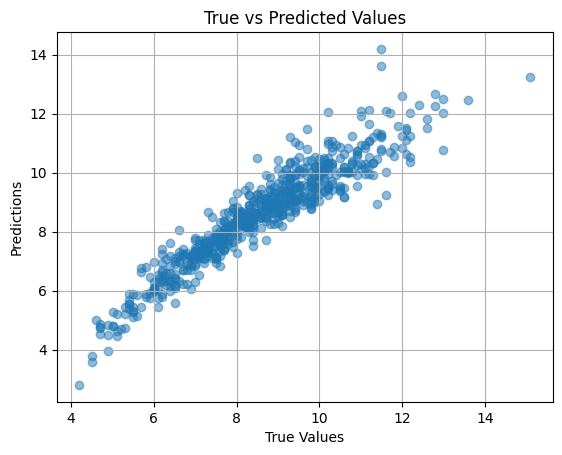

In [560]:
plt.scatter(y_test, y_pred_optimized_ridge, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.grid()
plt.show()

## COMPARING MODELS RESULTS

In [567]:
best_results = {
    "Linear Regression": best_result_linear,
    "Lasso Regression": best_result_Lasso,
    "Ridge Regression": best_result_ridge
}


In [568]:
print("Best Results for Each Model:\n")
for model_name, result in best_results.items():
    print(f"{model_name} - Dataset: {result['Dataset']}, "
          f"MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, "
          f"R²: {result['R²']:.5f}")


Best Results for Each Model:

Linear Regression - Dataset: X_train_with_outliers_norm_sel, MAE: 0.45, RMSE: 0.61, R²: 0.88303
Lasso Regression - Dataset: X_train_with_outliers_sel, MAE: 0.63, RMSE: 0.81, R²: 0.78917
Ridge Regression - Dataset: X_train_with_outliers_minmax_sel, MAE: 0.46, RMSE: 0.61, R²: 0.88336


The overall best model is Ridge Regression using dataset X_train_with_outliers_minmax_sel, with a MAE of 0.46, RMSE of 0.61, and R² score of 0.88336.

#### FINAL STATEMENT


The Ridge Regression model, applied to the dataset X_train_with_outliers_minmax_sel, demonstrated the best overall performance with a MAE of 0.46, RMSE of 0.61, and an R² of 0.88336. These results indicate that Ridge Regression effectively handles this dataset, maintaining robust generalization performance.

On the other hand, the optimized Lasso model, with an alpha of 0.1 and a maximum of 1000 iterations, achieved a MAE of 0.46, RMSE of 0.61, and an R² of 0.88177. Although slightly behind Ridge, the Lasso model remains competitive, offering the advantage of feature selection, which helps eliminate irrelevant variables and improve model interpretability.